<a href="https://colab.research.google.com/github/ameyark28/Generating-hand-written-digits-GANs-/blob/main/GANs_for_generating_hand_written_digits.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generative Adversarial Network (GAN)

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras

## Preparing the Data

In [2]:
mnist = tf.keras.datasets.mnist

In [3]:
(X_train, Y_train),(X_test, Y_test) = mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


In [4]:
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(60000, 28, 28)
(10000, 28, 28)
(60000,)
(10000,)


### A few images from the dataset

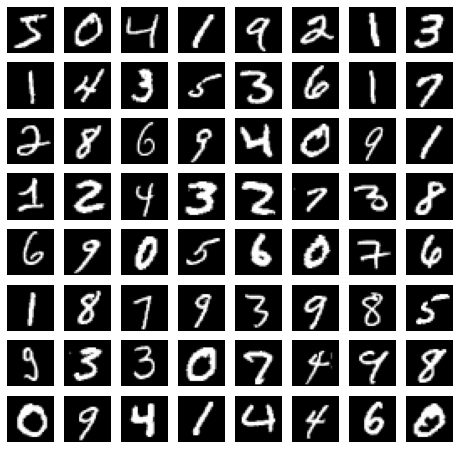

In [5]:
plt.figure(figsize=(8,8))
for i in range(64):
    plt.subplot(8, 8, 1+i)
    plt.axis('off')
    plt.imshow(X_train[i], cmap = 'gray')

In [6]:
X_train = X_train / 255

In [7]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder = True).prefetch(1)

## Creating the Generator

In [8]:
codings_size = 30

generator = keras.models.Sequential([
                keras.layers.Dense(128,activation = 'selu', input_shape = [codings_size]),
                keras.layers.Dense(256, activation = 'selu'),
                keras.layers.Dense(28*28, activation = 'sigmoid'),
                keras.layers.Reshape([28,28])
])

In [9]:
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               3968      
_________________________________________________________________
dense_1 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_2 (Dense)              (None, 784)               201488    
_________________________________________________________________
reshape (Reshape)            (None, 28, 28)            0         
Total params: 238,480
Trainable params: 238,480
Non-trainable params: 0
_________________________________________________________________


## Creating the Discriminator

In [10]:
discriminator = keras.models.Sequential([
                keras.layers.Flatten(input_shape = [28,28]),
                keras.layers.Dense(256, activation = 'selu'),
                keras.layers.Dense(128, activation = 'selu'),
                keras.layers.Dense(1, activation = 'sigmoid')
])

In [11]:
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               200960    
_________________________________________________________________
dense_4 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 129       
Total params: 233,985
Trainable params: 233,985
Non-trainable params: 0
_________________________________________________________________


## Combining Generator & Discriminator to form the GAN

In [12]:
gan = keras.models.Sequential([generator, discriminator])

In [13]:
gan.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 28, 28)            238480    
_________________________________________________________________
sequential_1 (Sequential)    (None, 1)                 233985    
Total params: 472,465
Trainable params: 472,465
Non-trainable params: 0
_________________________________________________________________


In [14]:
# The discriminator is trainable separately but not inside GAN
discriminator.compile(loss = 'binary_crossentropy', optimizer = 'rmsprop')
discriminator.trainable = False
gan.compile(loss = 'binary_crossentropy', optimizer = 'rmsprop')

## Function for Training

In [15]:
def train_gan(gan, dataset, batch_size, codings_size, n_epochs = 10):
  generator, discriminator = gan.layers
  for epoch in range(n_epochs):
    for X_batch in dataset:
      #training the discriminator
      noise = tf.random.normal(shape = [batch_size, codings_size])
      generated_images = generator(noise)
      X_batch = tf.cast(X_batch, tf.float32)
      X_fake_and_real = tf.concat([generated_images, X_batch], axis = 0)
      y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
      discriminator.trainable = True
      discriminator.train_on_batch(X_fake_and_real, y1)
      
      #training the gan (Generator)
      noise = tf.random.normal(shape = [batch_size, codings_size])
      y2 = tf.constant(([[1.]] * batch_size))
      discriminator.trainable = False
      gan.train_on_batch(noise, y2)
  
  # To produce final images
  plt.figure(figsize=(6,6))
  for i in range(32):
    plt.subplot(8, 4, 1+i)
    plt.axis('off')
    plt.imshow(generated_images[i], cmap = 'gray')

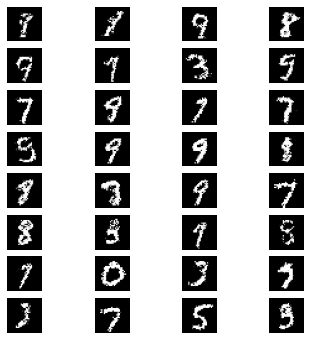

In [16]:
train_gan(gan, dataset, batch_size, codings_size)

## Generating an image

In [44]:
noise = tf.random.normal(shape = [1,codings_size])
generated_image = generator(noise)
generated_image.shape

TensorShape([1, 28, 28])

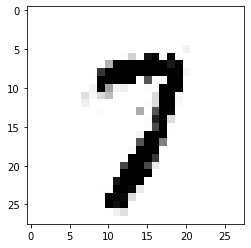

In [45]:
plt.figure()
plt.imshow(generated_image[0], cmap = 'gray_r')